## SETUP

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/drive/MyDrive/dataset_review_amazon/Dataset Pertama_train.csv')

# EDA

In [5]:
df.columns = ['sentiment', 'title', 'review']

In [6]:
df.head()

,sentiment,title,review
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   sentiment  int64 
 1   title      object
 2   review     object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [8]:
import seaborn as sns
sns.set_style('whitegrid')

In [9]:
df.isnull().sum()

,0
sentiment,0
title,207
review,0


/tmp/ipython-input-10-2253930509.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


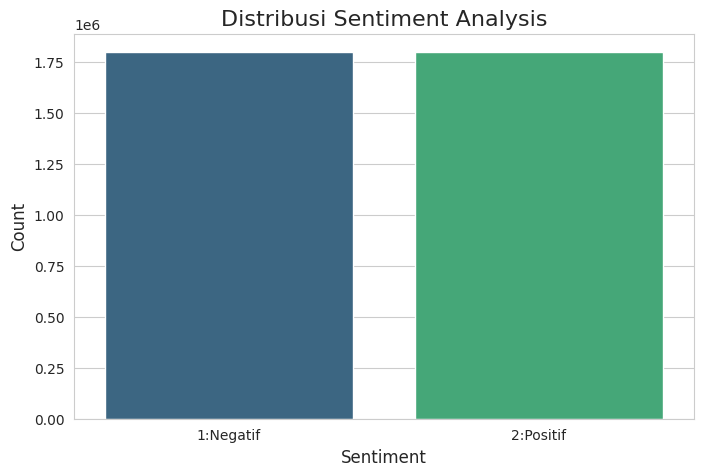

In [10]:
plt.figure(figsize =(8,5))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribusi Sentiment Analysis', fontsize=16)
plt.xlabel('Sentiment', fontsize =12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks = [0,1], labels=['1:Negatif', '2:Positif'])
plt.show()

In [11]:
df['text'] = df['title'].fillna('') + ' ' + df['review'].fillna('')
df['text_length'] = df['text'].apply(len)

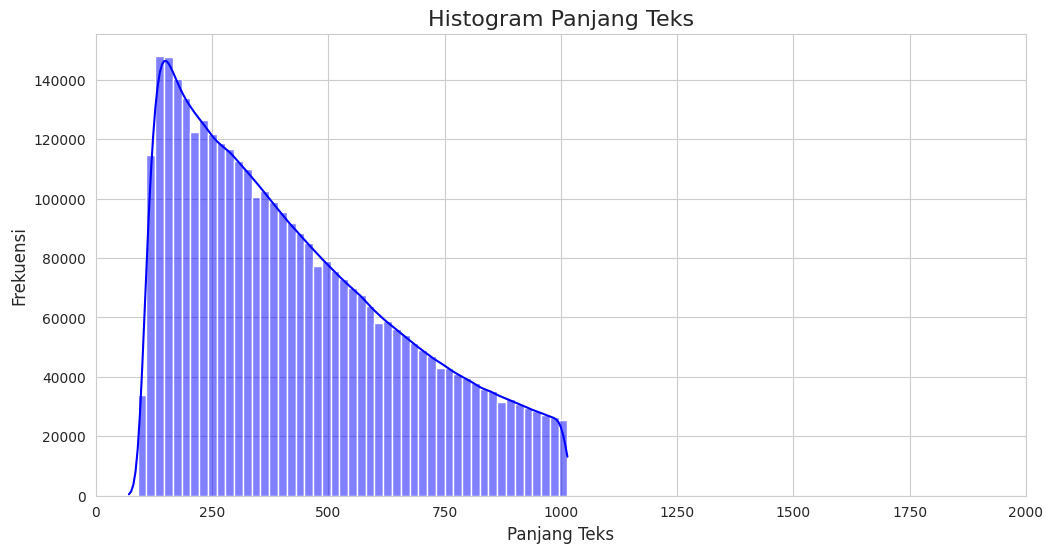

In [12]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='text_length', bins = 50, kde =True, color='blue')
plt.title('Histogram Panjang Teks', fontsize=16)
plt.xlabel('Panjang Teks', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.xlim(0,2000)
plt.show()

In [13]:
df['text_length'].describe()

,text_length
count,3.599999e+06
mean,4.306461e+02
std,2.375527e+02
min,7.100000e+01
25%,2.300000e+02
50%,3.820000e+02
75%,5.940000e+02
max,1.014000e+03


#Preprocessing & Cleaning Data

In [14]:
import re

def clean_text(text):
  text= text.lower()
  text = re.sub(r'[^a-zA-Z\s]','',text)
  text = ' '.join(text.split())
  return text

In [15]:
df['cleaned_text'] = df['text'].apply(clean_text)

In [16]:
df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,The best soundtrack ever to anything. I'm read...,the best soundtrack ever to anything im readin...
1,Amazing! This soundtrack is my favorite music ...,amazing this soundtrack is my favorite music o...
2,Excellent Soundtrack I truly like this soundtr...,excellent soundtrack i truly like this soundtr...
3,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...
4,an absolute masterpiece I am quite sure any of...,an absolute masterpiece i am quite sure any of...


# Build Model

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

In [18]:
X = df['cleaned_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
len(X_test)

720000

In [20]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words = 'english')),
    ('nb', MultinomialNB())
])

In [21]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi: {accuracy}')

report = classification_report(y_test, y_pred, target_names = ['Negatif (1)', 'Positif (2)'])
print(report)

Akurasi: 0.8399208333333333
              precision    recall  f1-score   support

 Negatif (1)       0.84      0.84      0.84    360585
 Positif (2)       0.84      0.84      0.84    359415

    accuracy                           0.84    720000
   macro avg       0.84      0.84      0.84    720000
weighted avg       0.84      0.84      0.84    720000



In [22]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
_, X_train_small, _, y_train_small = train_test_split(X_train, y_train, test_size=50000, random_state=42, stratify=y_train)
_, X_test_small, _, y_test_small = train_test_split(X_test, y_test, test_size=10000, random_state=42, stratify=y_test)

In [25]:
len(X_train_small)

50000

In [26]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(X_train_small.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_small.tolist(), truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [27]:
class AmazonReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels.iloc[idx]) - 1)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AmazonReviewDataset(train_encodings, y_train_small)
test_dataset = AmazonReviewDataset(test_encodings, y_test_small)

In [28]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [29]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    report_to="none",
    eval_strategy="epoch"
)

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.195900,0.174032
2,0.101200,0.202806


TrainOutput(global_step=6250, training_loss=0.17334178970336914, metrics={'train_runtime': 1676.9827, 'train_samples_per_second': 59.631, 'train_steps_per_second': 3.727, 'total_flos': 3311684966400000.0, 'train_loss': 0.17334178970336914, 'epoch': 2.0})

In [31]:
eval_results = trainer.evaluate()

In [39]:
print(eval_results)

{'eval_loss': 0.20280618965625763, 'eval_runtime': 36.7497, 'eval_samples_per_second': 272.111, 'eval_steps_per_second': 4.272, 'epoch': 2.0}


# Testing

In [32]:
def predict_naive_bayes(text_input):
    prediction = pipeline.predict([text_input])
    if prediction[0] == 1:
        return "Negatif"
    else:
        return "Positif"

In [33]:
def predict_distilbert(text_input):
    model = trainer.model
    model.eval()
    cleaned_text = clean_text(text_input)
    inputs = tokenizer(cleaned_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    prediction_idx = torch.argmax(outputs.logits, dim=1).item()
    if prediction_idx == 0:
        return "Negatif"
    else:
        return "Positif"

In [45]:
while True:
    user_text = input("Masukkan ulasan (atau ketik 'keluar' untuk berhenti): ")
    if user_text.lower() == 'keluar':
        print("Sesi selesai. Terima kasih!")
        break

    nb_result = predict_naive_bayes(user_text)
    distilbert_result = predict_distilbert(user_text)

    print(f"\nInput: '{user_text}'")
    print(f"Prediksi Naive Bayes: {nb_result}")
    print(f"Prediksi DistilBERT : {distilbert_result}\n")

Masukkan ulasan (atau ketik 'keluar' untuk berhenti): This camera takes amazing pictures, the quality is stunning!

Input: 'This camera takes amazing pictures, the quality is stunning!'
Prediksi Naive Bayes: Positif
Prediksi DistilBERT : Positif

Masukkan ulasan (atau ketik 'keluar' untuk berhenti): I couldn't believe this would actually work, but I was completely wrong. The device I initially dismissed has become the solution to all my problems. Highly recommended.

Input: 'I couldn't believe this would actually work, but I was completely wrong. The device I initially dismissed has become the solution to all my problems. Highly recommended.'
Prediksi Naive Bayes: Negatif
Prediksi DistilBERT : Positif

Masukkan ulasan (atau ketik 'keluar' untuk berhenti): I was very skeptical at first, the price was cheap and the box looked flimsy. I honestly thought this would be a dud. But after trying it, the performance is absolutely incredible! Way above my expectations

Input: 'I was very skeptic

# Save Model

In [41]:
import joblib

!mkdir -p /content/drive/MyDrive/saved_models/

joblib.dump(pipeline, '/content/drive/MyDrive/saved_models/naive_bayes_pipeline.joblib')

['/content/drive/MyDrive/saved_models/naive_bayes_pipeline.joblib']

In [42]:
model_to_save = trainer.model
output_dir_distilbert = '/content/drive/MyDrive/saved_models/distilbert_sentiment_model'

model_to_save.save_pretrained(output_dir_distilbert)
tokenizer.save_pretrained(output_dir_distilbert)


('/content/drive/MyDrive/saved_models/distilbert_sentiment_model/tokenizer_config.json',
 '/content/drive/MyDrive/saved_models/distilbert_sentiment_model/special_tokens_map.json',
 '/content/drive/MyDrive/saved_models/distilbert_sentiment_model/vocab.txt',
 '/content/drive/MyDrive/saved_models/distilbert_sentiment_model/added_tokens.json')